In [1]:
#### IMPORTING LIBRARIES ####
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from scipy.io import wavfile 
from scipy.signal import chirp, spectrogram
from scipy.optimize import minimize
import IPython
from playsound import playsound 
import simpleaudio as sa


In [2]:
#### GENERATING THE SINE SWEEP ####
w1 = 1
w2 = 1
fs = 44100
T = 1
t = np.linspace(0,T,T*fs)
sweep = np.sin((w1*T/np.log(w2/w1))*(np.exp((t/T)*np.log(w2/w1)) - 1))
audio = sweep * (2**15 - 1) / np.max(np.abs(sweep))
audio = audio.astype(np.int16)

c:\users\salma\documents\manuel\universidad\master\segundoaño\segundo\project course\calibration\project-course\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
c:\users\salma\documents\manuel\universidad\master\segundoaño\segundo\project course\calibration\project-course\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


In [93]:
#play_obj = sa.play_buffer(audio, 1, 2, fs)
#play_obj.wait_done()
wavfile.write('sweep3266641.wav', fs, audio)
playsound('sweep3266641.wav')

(0.0, 4.0)

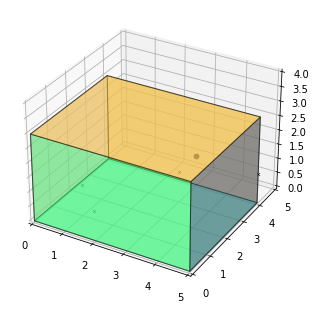

In [136]:
#### DESIGNING THE ROOM ####

pol = np.array([[0,0], [0,4], [5,4], [5,0]]).T
room = pra.Room.from_corners(pol, fs=16000, max_order=10, absorption=0.1)
room.extrude(3)
# Adding the source
Xsource = [3]
Ysource = [4]
Zsource = [1]
room.add_source(np.array([Xsource, Ysource,Zsource]), signal= 'sweep3266641.wav')

# Adding the microphone
Xmics = [3,5,2,1]
Ymics =[3,4,0,1]
Zmics = [1,1,1,1]
R = np.array([Xmics,Ymics,Zmics])
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()
ax.set_xlim([0,5])
ax.set_ylim([0,5])
ax.set_zlim([0,4])

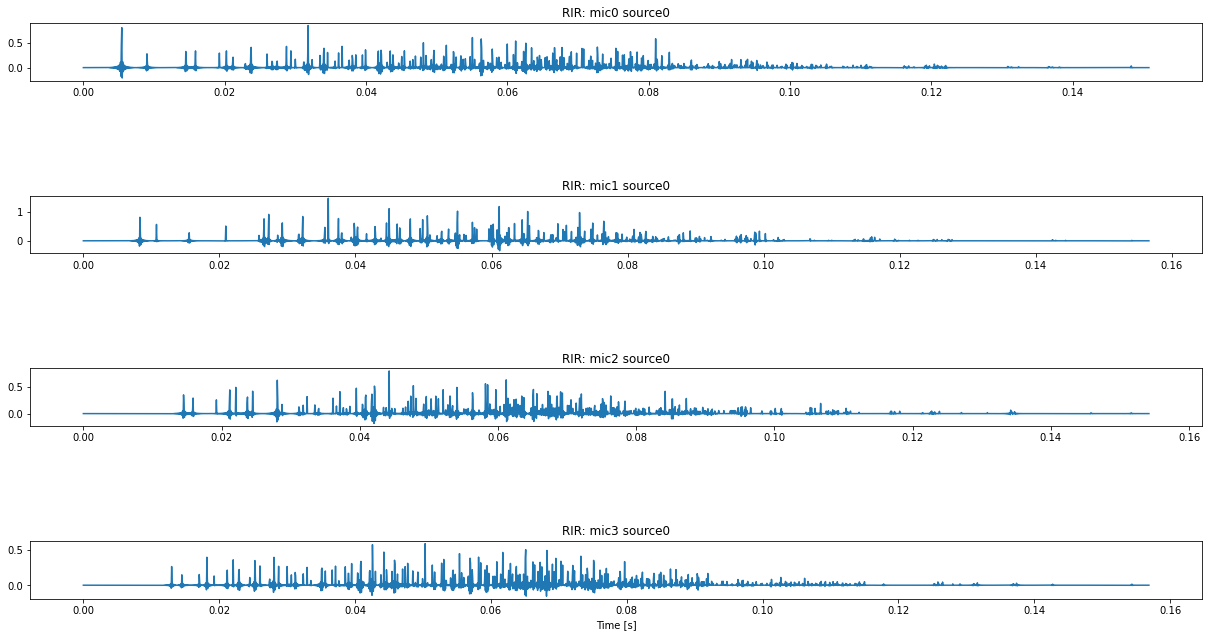

In [137]:
#### COMPUTING RIR ####
RIR = room.compute_rir()
# Plot and apply the RIR on the audio file
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
RIRR = plt.show()
#room.simulate()
#room.mic_array.to_wav('aaa.wav', norm=True, bitdepth=np.int16)

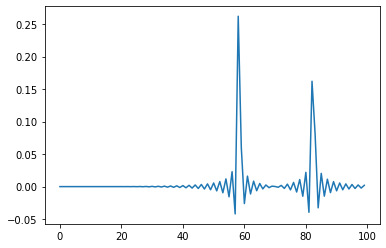

In [78]:

plt.plot(room.rir[0][0][150:250])

In [50]:
IPython.display.Audio(audio, rate = fs)

In [57]:
room.simulate()
IPython.display.Audio(room.mic_array.signals[1,:], rate = fs)

In [78]:
#### Computing time of first reflection ####
time = 0;
for n in range(1,len(room.rir[1][0]) - 1):
    if ((room.rir[0][0][n - 1] < room.rir[0][0][n]) & (room.rir[0][0][n + 1] < room.rir[0][0][n]) & (room.rir[0][0][n] > np.mean(room.rir[0][0]))):
        time = n/16000;
        print('Room Impulse Response empieza en: ', time, 'segundos')
        print('Muestra numero:', n)
        break;

Room Impulse Response empieza en:  0.004625 segundos
Muestra numero: 74


In [170]:
#### Computing distance between mic and speaker ####
## Si obtenemos la distancia teniendo en cuenta el primer valor
## que no es 0 en el RIR, no hay que restar al tiempo un valor
## delta.
Xmics_ = np.asarray(Xmics)
Ymics_ = np.asarray(Ymics)
Zmics_ = np.asarray(Zmics)
c = 343.2 #Velocidad del sonido en m/s
delta = 0.0025 #Delay del aparato (2 ms)
distance = (time -delta )* c;
distance_real = []
for i in range(0, len(Xmics)):
    distance_real.append(np.sqrt(abs(Xsource - Xmics_[i])**2 + abs(Ysource - Ymics_[i])**2))
print('Distancia real entre micro0 y altavoz:', distance_real[0], 'metros');
print('Distancia real entre micro1 y altavoz:', distance_real[1], 'metros');
print('Distancia real entre micro2 y altavoz:', distance_real[2], 'metros');
print('Distancia real entre micro3 y altavoz:', distance_real[3], 'metros');
print('Distancia mediante RIR entre micrófono y altavoz:', distance, 'metros') 

Distancia real entre micro0 y altavoz: [1.] metros
Distancia real entre micro1 y altavoz: [2.] metros
Distancia real entre micro2 y altavoz: [4.12310563] metros
Distancia real entre micro3 y altavoz: [3.60555128] metros
Distancia mediante RIR entre micrófono y altavoz: 0.7292999999999998 metros


In [186]:
    P = []
    for i in range(0, len(Xmics)):
        P.append((np.sqrt(abs(3 - Xmics[i])**2 + abs(3 - Ymics[i])**2)))
        
P

[0.0, 2.23606797749979, 3.1622776601683795, 2.8284271247461903]

In [208]:
def fun2(x1):
  
    P = [0,0,0,0];
    D = [0,0,0,0];
    for i in range(0, len(Xmics)):
        P[i] = (np.sqrt(abs(x1[0] - Xmics[i])**2 + abs(x1[1] - Ymics[i])**2))
        D[i] = (np.sqrt(abs(Xsource - Xmics_[i])**2 + abs(Ysource - Ymics_[i])**2))
    P = np.array(P).T
    D = np.array(D).T
    print(D)
    print(P)
    #P = [(np.sqrt(abs(x1[0] - Xmics[0])**2 + abs(x1[1] - Ymics[0])**2)), (np.sqrt(abs(x1[0] - Xmics[1])**2 + abs(x1[1] - Ymics[1])**2)), (np.sqrt(abs(x1[0] - Xmics[2])**2 + abs(x1[1] - Ymics[2])**2)),(np.sqrt(abs(x1[0] - Xmics[3])**2 + abs(x1[1] - Ymics[3])**2))]
    #D = [distance_real[0], distance_real[1],distance_real[2],distance_real[3]]
    return (P - D)**2;
bndsM = ((0,5),(0,4))
#resM = minimize(fun2, (2,2), method='SLSQP', bounds=bndsM)
fun2([3,4])
#resM.x

[[1.         2.         4.12310563 3.60555128]]
[1.         2.         4.12310563 3.60555128]


array([[0., 0., 0., 0.]])

In [163]:
def fun2(x1):
    P = np.array([(np.sqrt(abs(x1[0] - x_mic0)**2 + abs(x1[1] - y_mic0)**2)), (np.sqrt(abs(x1[0] - x_mic1)**2 + abs(x1[1] - y_mic1)**2))])
    D = np.array([distance_real0, distance_real1])
    return sum((P - D)**2);

fun2([3.8,2.4])

array([1., 1.])

In [70]:
np.sqrt(abs(-0.12831171 - x_mic0)**2 + abs(0.39109573 - y_mic0)**2)
print(np.sqrt(abs(0 - x_mic0)**2 + abs(0 - y_mic0)**2))
print(np.sqrt(abs(0 - x_mic0)**2 + abs(2.00000024 - y_mic0)**2))

3.605551275463989
3.0000000000000093
